# Análisis de Datos de Accidentes de Tránsito en Monterrey

### Importaciones y Configuración

In [1]:

# Visualización
import matplotlib.pyplot as plt
import matplotlib as mpl
import scikitplot as skplt
import seaborn as sns
import prince
import folium

# Manupulación
from sklearn import preprocessing
import pandas as pd
import numpy as np

# Algoritmos
from kmodes.kprototypes import KPrototypes
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler

# Otros
from tqdm import tqdm_notebook as tqdm
from random import shuffle
import shapefile
from itertools import cycle, islice
from cycler import cycler
import glob
import gc


In [3]:

tqdm().pandas()
pd.set_option("display.max_columns", 500)


In [4]:

# colores: https://matplotlib.org/examples/color/colormaps_reference.html
# https://matplotlib.org/examples/color/named_colors.html
# gráficas: https://informationisbeautiful.net/


### Métodos

In [5]:

def concat_involucrados(x):
    """
    Concatena tipos de vehículos involucrados en un siniestro. 
    """
    return x.values[0] if len(x) == 1 else "-".join([vehiculo for vehiculo in x])


### Lectura de Datos

In [6]:

datos_mty = pd.read_csv("../datos/datos_limpios.csv")
datos_mty.head()


,ID_ENTIDAD,ID_MUNICIPIO,NOM_MUNICIPIO,NOM_ENTIDAD,COBERTURA,ANIO,MES,ID_HORA,ID_MINUTO,ID_DIA,DIASEMANA,TIPACCID,AUTOMOVIL,CAMPASAJ,MICROBUS,PASCAMION,OMNIBUS,TRANVIA,CAMIONETA,CAMION,TRACTOR,FERROCARRI,MOTOCICLET,BICICLETA,OTROVEHIC,CAUSAACCI,CAPAROD,SEXO,ALIENTO,CINTURON,ID_EDAD,CONDMUERTO,CONDHERIDO,PASAMUERTO,PASAHERIDO,PEATMUERTO,PEATHERIDO,CICLMUERTO,CICLHERIDO,OTROMUERTO,OTROHERIDO,NEMUERTO,NEHERIDO,CLASACC,ESTATUS,FECHA,RANGO_EDAD,ZONA,FECHA_COMPLETA,FECHA_DIF
0,19,21,General Escobedo,Nuevo León,Municipal,2007,1,0,0,1,Lunes,Colisión con objeto fijo,1,0,0,0,0,0,0,0,0,0,0,0,0,Conductor,Pavimentada,Hombre,Sí,Se ignora,41,0,1,0,0,0,0,0,0,0,0,0,0,No fatal,Cifras definitivas,2007-01-01 00:00:00,[35 - 45),Accidente en intersección,2007-01-01 00:00:00,NaN
1,19,26,Guadalupe,Nuevo León,Municipal,2007,1,0,17,1,Lunes,Colisión con vehículo automotor,1,0,0,0,0,0,1,0,0,0,0,0,0,Conductor,Pavimentada,Hombre,No,Se ignora,55,0,0,0,0,0,0,0,0,0,0,0,0,Sólo Daños,Cifras definitivas,2007-01-01 00:00:00,[45 - 55),Accidente en intersección,2007-01-01 00:17:00,0 days 00:17:00.000000000
2,19,26,Guadalupe,Nuevo León,Municipal,2007,1,1,24,1,Lunes,Colisión con vehículo automotor,2,0,0,0,0,0,0,0,0,0,0,0,0,Conductor,Pavimentada,Hombre,No,Se ignora,42,0,0,0,0,0,0,0,0,0,0,0,0,Sólo Daños,Cifras definitivas,2007-01-01 00:00:00,[35 - 45),Accidente en intersección,2007-01-01 01:24:00,0 days 01:07:00.000000000
3,19,19,San Pedro Garza García,Nuevo León,Municipal,2007,1,1,38,1,Lunes,Otro,1,0,0,0,0,0,0,0,0,0,0,0,1,Conductor,Pavimentada,Mujer,No,No,39,0,0,0,0,0,0,0,0,0,0,0,0,Sólo Daños,Cifras definitivas,2007-01-01 00:00:00,[35 - 45),Accidente en intersección,2007-01-01 01:38:00,0 days 00:14:00.000000000
4,19,46,San Nicolás de los Garza,Nuevo León,Municipal,2007,1,1,44,1,Lunes,Colisión con vehículo automotor,2,0,0,0,0,0,0,0,0,0,0,0,0,Conductor,Pavimentada,Hombre,Sí,Sí,27,0,1,0,1,0,0,0,0,0,0,0,0,No fatal,Cifras definitivas,2007-01-01 00:00:00,[25 - 35),Accidente en intersección,2007-01-01 01:44:00,0 days 00:06:00.000000000


### Clustering

In [7]:

involucrados = datos_mty[[
    'AUTOMOVIL', 'CAMPASAJ', 'MICROBUS', 'PASCAMION',
    'OMNIBUS', 'TRANVIA', 'CAMIONETA', 'CAMION', 'TRACTOR',
    'FERROCARRI', 'MOTOCICLET', 'BICICLETA', 'OTROVEHIC'
]]
vehiculo_tmp = involucrados.stack().fillna(0)
vehiculo_tmp = vehiculo_tmp[vehiculo_tmp != 0]
tmp_var = vehiculo_tmp.reset_index().groupby("level_0")["level_1"].progress_apply(concat_involucrados)
datos_mty["INVOLUCRADOS"] = tmp_var


In [8]:

le = preprocessing.LabelEncoder()
datos_mty["DIA_SEMANA_NUM"] = le.fit_transform(datos_mty["DIASEMANA"])
datos_mty["DIA_SEMANA_NUM"]

vars_clust = [
    'NOM_MUNICIPIO', 'MES', 'DIA_SEMANA_NUM', 'TIPACCID',  'OTROVEHIC', 'CAUSAACCI',
    'CAPAROD', 'SEXO', 'ALIENTO', 'CINTURON', 'ID_EDAD', 'CLASACC','ZONA', 'INVOLUCRADOS'
]

datos_clust = datos_mty[vars_clust]
datos_clust.head()

datos_clust["OTROVEHIC"] = datos_clust["OTROVEHIC"].astype(str)

numericos = ["int16", "int32", "int64", "float16", "float32", "float64"]
cols_numericas = datos_clust.select_dtypes(include=numericos).columns


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [9]:

escalados = []

for col in cols_numericas:
    
    scaler = MinMaxScaler()
    escalados.append(pd.Series(scaler.fit_transform(datos_clust[col].values.reshape(-1, 1)).ravel()))

escalados_df = pd.concat(escalados, axis=1)
escalados_df.columns = cols_numericas
escalados_df.index = datos_clust.index

datos_clust.update(escalados_df)
datos_clust.head()


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expres

,NOM_MUNICIPIO,MES,DIA_SEMANA_NUM,TIPACCID,OTROVEHIC,CAUSAACCI,CAPAROD,SEXO,ALIENTO,CINTURON,ID_EDAD,CLASACC,ZONA,INVOLUCRADOS
0,General Escobedo,0.0,0.333333,Colisión con objeto fijo,0,Conductor,Pavimentada,Hombre,Sí,Se ignora,0.316456,No fatal,Accidente en intersección,AUTOMOVIL
1,Guadalupe,0.0,0.333333,Colisión con vehículo automotor,0,Conductor,Pavimentada,Hombre,No,Se ignora,0.493671,Sólo Daños,Accidente en intersección,AUTOMOVIL-CAMIONETA
2,Guadalupe,0.0,0.333333,Colisión con vehículo automotor,0,Conductor,Pavimentada,Hombre,No,Se ignora,0.329114,Sólo Daños,Accidente en intersección,AUTOMOVIL
3,San Pedro Garza García,0.0,0.333333,Otro,1,Conductor,Pavimentada,Mujer,No,No,0.291139,Sólo Daños,Accidente en intersección,AUTOMOVIL-OTROVEHIC
4,San Nicolás de los Garza,0.0,0.333333,Colisión con vehículo automotor,0,Conductor,Pavimentada,Hombre,Sí,Sí,0.139241,No fatal,Accidente en intersección,AUTOMOVIL


In [10]:

tipos_vars = datos_clust.dtypes.reset_index()
vars_cat = tipos_vars[tipos_vars[0] == "object"].index.tolist()
vars_cat


[0, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13]

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10


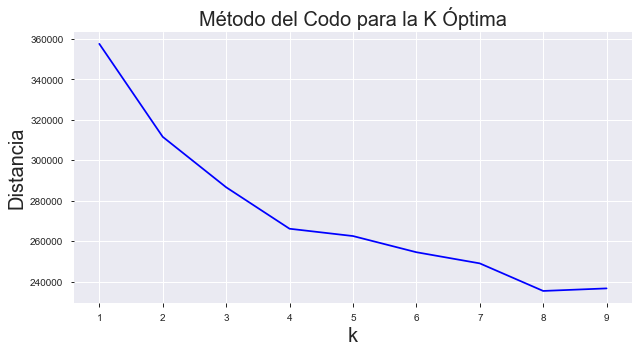

In [29]:

distancias = []
n_pruebas = 10
K = list(range(1, n_pruebas))

for k in K:
    
    print(str(k) + " / " + str(n_pruebas))
    kproto = KPrototypes(n_clusters=k, init="Cao", verbose=2, n_init=1, n_jobs=-1, max_iter=2, random_state=42)
    clusters = kproto.fit_predict(datos_clust, categorical=vars_cat)
    distancias.append(kproto.cost_)

plt.figure(figsize=(10,5))

plt.plot(
    K,
    distancias,
    "bx-"
)
plt.xlabel("k", fontsize=20)
plt.ylabel("Distancia", fontsize=20)
plt.title("Método del Codo para la K Óptima", fontsize=20)
plt.show()


In [11]:

hyper_params = {
    "n_init": 2,
    "n_clusters": 5,
    "init": "Cao",
    "verbose": 2,
    "n_jobs": -1,
    "random_state":42
}

kproto = KPrototypes(**hyper_params)
modelo = kproto.fit(datos_clust, categorical=vars_cat)

clusters = modelo.predict(datos_clust, categorical=vars_cat)

clusters +=1

display(modelo.cluster_centroids_)


Best run was number 2


[array([[0.76146989, 0.79499278, 0.24510643],
        [0.78042884, 0.30077987, 0.2475565 ],
        [0.38392948, 0.48244907, 0.24451527],
        [0.21309103, 0.77891329, 0.24571276],
        [0.3088841 , 0.20962274, 0.24495527]]),
 array([['Monterrey', 'Colisión con vehículo automotor', '0', 'Conductor',
         'Pavimentada', 'Hombre', 'No', 'Sí', 'Sólo Daños',
         'Accidente en intersección', 'AUTOMOVIL'],
        ['San Nicolás de los Garza', 'Colisión con vehículo automotor',
         '0', 'Conductor', 'Pavimentada', 'Hombre', 'No', 'No',
         'Sólo Daños', 'Accidente en intersección', 'AUTOMOVIL'],
        ['San Pedro Garza García', 'Colisión con vehículo automotor', '0',
         'Conductor', 'Pavimentada', 'Mujer', 'No', 'Sí', 'Sólo Daños',
         'Accidente en intersección', 'AUTOMOVIL-PASCAMION'],
        ['Monterrey', 'Colisión con vehículo automotor', '0', 'Conductor',
         'Pavimentada', 'Hombre', 'No', 'No', 'Sólo Daños',
         'Accidente en intersección

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


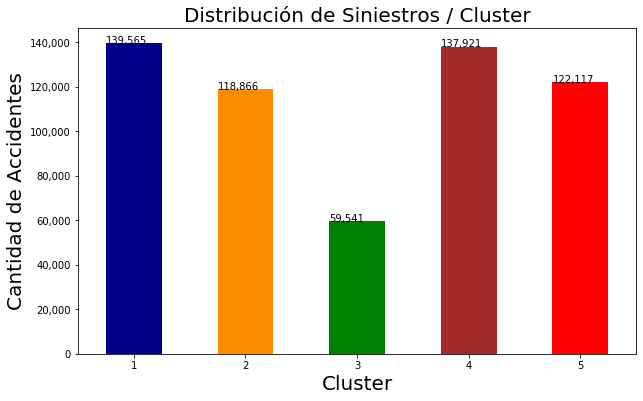

In [12]:


datos_clust["cluster"] = clusters
densidad_clusters = datos_clust["cluster"].value_counts().sort_index()

ax = plt.subplot(111)

colores = list(
    islice(
        cycle(["darkblue", "darkorange", "green", "brown", "red"]),
        None,
        len(densidad_clusters)
    )
)

ax = densidad_clusters.plot(
    ax=ax,
    kind="bar",
    rot=0,
    figsize=(10, 6),
    color=colores
)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

for p in ax.patches:
    
    dato = format(p.get_height(), ",")
    ax.annotate(dato, (p.get_x() * 1, p.get_height() * 1))

plt.title("Distribución de Siniestros / Cluster", fontsize=20)
plt.xlabel("Cluster", fontsize=20)
plt.ylabel("Cantidad de Accidentes", fontsize=20)
plt.show()


In [13]:

datos_mty["cluster"] = clusters

datos_mty["grupo"] = datos_mty.progress_apply(
    lambda x:
    "Cluster 2" if x["cluster"] == 2
    else "Otros",
    axis=1
)


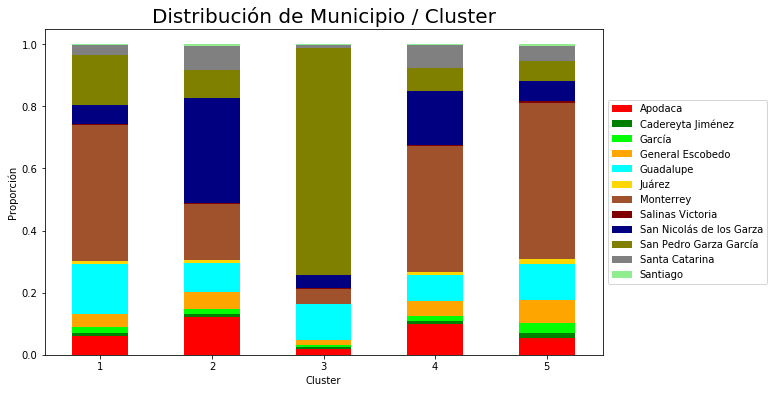

In [17]:

pivot = pd.pivot_table(datos_mty, index="cluster", columns="NOM_MUNICIPIO", aggfunc="size")
pivot = pivot.div(pivot.sum(axis=1), axis=0)
colores = [
    "red", "green", "lime", "orange", "aqua", "gold", "sienna", "maroon", "navy", "olive", "gray", "lightgreen",
    "yellow","white","pink"
]
ax = pivot.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    rot = 0,
    color=colores
)
plt.title("Distribución de Municipio / Cluster", fontsize=20)
plt.xlabel("Cluster")
plt.ylabel("Proporción")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()


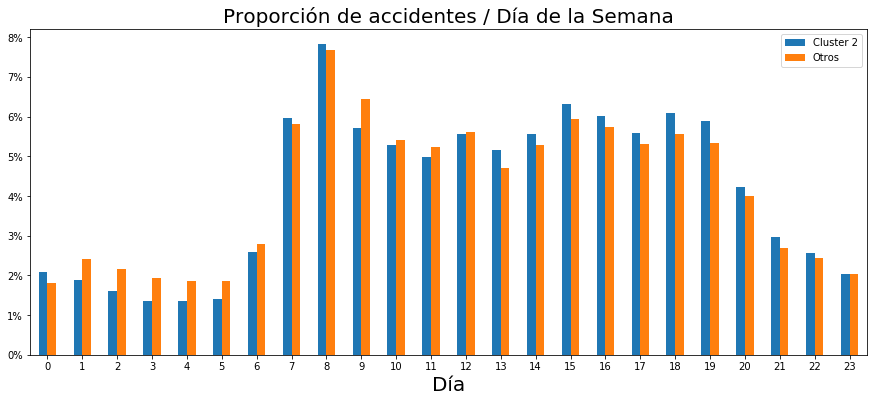

In [15]:

#involucrados_clust = datos_mty["INVOLUCRADOS"].value_counts(normalize=True).head(10).index
#datos_mty_tmp = datos_mty[datos_mty["INVOLUCRADOS"].isin(involucrados_clust)]

pivot = pd.pivot_table(
    data=datos_mty,
    index="ID_HORA",
    columns="grupo",
    aggfunc="size"
)

pivot = 100 * pivot.div(pivot.sum(axis=0), axis=1)
#pivot = pivot.loc["Conductor"].to_frame().T
#pivot = pivot.loc["No"].to_frame().T
#pivot.drop("Accidente en intersección", inplace=True)
ax = pivot.plot(
    kind="bar",
    rot=0,
    figsize=(15, 6),
    #fontsize=10
)
ax.legend(["Cluster 2", "Otros"])
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:}%".format(int(x))))

plt.title("Proporción de accidentes / Día de la Semana", fontsize=20)
plt.xlabel("Día", fontsize=20)
#ax.set_xticklabels(["Lunes", "Mates", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"])
plt.show()


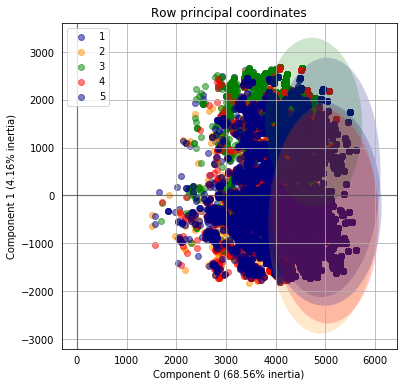

In [16]:

plt.rcParams["axes.prop_cycle"] = cycler(
    color=[
        "darkblue", "darkorange", "green", "red", "navy"
    ]
)

X_famd = datos_clust.copy().drop("cluster", axis=1)

famd = prince.FAMD(n_components=3, n_iter=2, copy=True, check_input=True, engine="auto", random_state=42)
famd = famd.fit(X_famd)

ax = famd.plot_row_coordinates(
    X_famd,
    ax=None,
    figsize=(6, 6),
    x_component=0,
    y_component=1,
    color_labels=[t for t in clusters],
    ellipse_outline=False,
    ellipse_fill=True,
    show_points=True,
    alpha=0.5
)

plt.grid(True)


In [18]:

datos_desc = datos_mty.copy()
datos_desc[[
    "ANIO", "MES", "AUTOMOVIL", "CAMPASAJ", "MICROBUS", "PASCAMION",
    "OMNIBUS", "TRANVIA", "CAMIONETA", "CAMION", "TRACTOR", "FERROCARRI", "MOTOCICLET",
    "BICICLETA", "OTROVEHIC","CONDMUERTO", "CONDHERIDO", "PASAMUERTO", "PASAHERIDO", "ANIO", "MES", "ID_HORA",
    "PEATMUERTO", "PEATHERIDO", "CICLMUERTO","CICLHERIDO", "OTROMUERTO", "OTROHERIDO", "NEMUERTO", "NEHERIDO"
]] = datos_desc[[
    "ANIO", "MES", "AUTOMOVIL", "CAMPASAJ", "MICROBUS", "PASCAMION",
    "OMNIBUS", "TRANVIA", "CAMIONETA", "CAMION", "TRACTOR", "FERROCARRI", "MOTOCICLET",
    "BICICLETA", "OTROVEHIC","CONDMUERTO", "CONDHERIDO", "PASAMUERTO", "PASAHERIDO","ANIO", "MES", "ID_HORA",
    "PEATMUERTO", "PEATHERIDO", "CICLMUERTO","CICLHERIDO", "OTROMUERTO", "OTROHERIDO", "NEMUERTO", "NEHERIDO"
]].astype(str)


In [19]:

datos_desc.describe(include="all").loc[["top", "mean"]]


,ID_ENTIDAD,ID_MUNICIPIO,NOM_MUNICIPIO,NOM_ENTIDAD,COBERTURA,ANIO,MES,ID_HORA,ID_MINUTO,ID_DIA,DIASEMANA,TIPACCID,AUTOMOVIL,CAMPASAJ,MICROBUS,PASCAMION,OMNIBUS,TRANVIA,CAMIONETA,CAMION,TRACTOR,FERROCARRI,MOTOCICLET,BICICLETA,OTROVEHIC,CAUSAACCI,CAPAROD,SEXO,ALIENTO,CINTURON,ID_EDAD,CONDMUERTO,CONDHERIDO,PASAMUERTO,PASAHERIDO,PEATMUERTO,PEATHERIDO,CICLMUERTO,CICLHERIDO,OTROMUERTO,OTROHERIDO,NEMUERTO,NEHERIDO,CLASACC,ESTATUS,FECHA,RANGO_EDAD,ZONA,FECHA_COMPLETA,FECHA_DIF,INVOLUCRADOS,DIA_SEMANA_NUM,cluster,grupo
top,NaN,NaN,Monterrey,Nuevo León,Municipal,2014,3,8,NaN,NaN,Viernes,Colisión con vehículo automotor,1,0,0,0,0,0,0,0,0,0,0,0,0,Conductor,Pavimentada,Hombre,No,Sí,NaN,0,0,0,0,0,0,0,0,0,0,0,0,Sólo Daños,Cifras definitivas,2015-03-01 00:00:00,[25 - 35),Accidente en intersección,2016-11-19 00:00:00,0 days 00:00:00.000000000,AUTOMOVIL,NaN,NaN,Otros
mean,19.0,31.54438,NaN,NaN,NaN,NaN,NaN,NaN,27.254859,15.700026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.407308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.201932,2.972594,NaN


In [24]:

condiciones_prom = [
    "Monterrey", "Abril", "8", "Viernes", "Colisión con vehículo automotor", "Automovil", "Conductor", "Pavimentada",
    "Hombre", "Sin Aliento", "Con cinturón", "35 años", "Sólo Daños", "Accidente en intersección",
    "GONZALITOS", "Poniente a Oriente", "Alcance", "Seco", "Vigente"
]

condiciones_prom_ds = pd.Series(condiciones_prom)
condiciones_prom_ds.index = [
    "Municipio", "Mes", "Hora", "Día Semana", "Tipo", "Involucrado", "Causa", "Condiciones", "Sexo",
    "Aliento", "Cinturón", "Edad", "Daño", "Ubicación", "Avenida", "Dirección", "Accidente", "Clima", "Licencia"
]
condiciones_prom_ds.to_frame()


,0
Municipio,Monterrey
Mes,Abril
Hora,8
Día Semana,Viernes
Tipo,Colisión con vehículo automotor
Involucrado,Automovil
Causa,Conductor
Condiciones,Pavimentada
Sexo,Hombre
Aliento,Sin Aliento


In [22]:

# Revisamos centroides.
"""c1 = modelo.cluster_centroids_[0][0, :].tolist() + modelo.cluster_centroids_[1][0, :].tolist()
c2 = modelo.cluster_centroids_[0][1, :].tolist() + modelo.cluster_centroids_[1][1, :].tolist()
c3 = modelo.cluster_centroids_[0][2, :].tolist() + modelo.cluster_centroids_[1][2, :].tolist()
c4 = modelo.cluster_centroids_[0][3, :].tolist() + modelo.cluster_centroids_[1][3, :].tolist()
c5 = modelo.cluster_centroids_[0][4, :].tolist() + modelo.cluster_centroids_[1][4, :].tolist()

centroides = pd.DataFrame([c1, c2, c3, c4, c5]).T
centroides.columns = ["c1", "c2", "c3", "c4", "c5"]
centroides.index = datos_clust.columns[::-1]

centroides""";
